In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.columns = train_data.columns.str.lower()
train_data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.columns = test_data.columns.str.lower()
test_data.head()

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  418 non-null    int64  
 1   pclass       418 non-null    int64  
 2   name         418 non-null    object 
 3   sex          418 non-null    object 
 4   age          332 non-null    float64
 5   sibsp        418 non-null    int64  
 6   parch        418 non-null    int64  
 7   ticket       418 non-null    object 
 8   fare         417 non-null    float64
 9   cabin        91 non-null     object 
 10  embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
train_data['family'] = train_data['sibsp'] + train_data['parch']
test_data['family'] = test_data['sibsp'] + test_data['parch']

train_data['is_alone'] = train_data['family'] == 0
test_data['is_alone'] = test_data['family'] == 0

train_data = train_data.drop(['ticket', 'cabin'], axis=1)
test_data = test_data.drop(['ticket', 'cabin'], axis=1)

In [7]:
# посмотрим пропуск fare
test_data[test_data['fare'].isna() == True]
# заполним медианой 3 класса мужского пола
median_test_fare_isna = test_data[(test_data['fare'].isna() == False) & (test_data['pclass'] == 3) & (test_data['sex'] == 'male')]['fare'].median()
test_data['fare'] = test_data['fare'].fillna(median_test_fare_isna)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  418 non-null    int64  
 1   pclass       418 non-null    int64  
 2   name         418 non-null    object 
 3   sex          418 non-null    object 
 4   age          332 non-null    float64
 5   sibsp        418 non-null    int64  
 6   parch        418 non-null    int64  
 7   fare         418 non-null    float64
 8   embarked     418 non-null    object 
 9   family       418 non-null    int64  
 10  is_alone     418 non-null    bool   
dtypes: bool(1), float64(2), int64(5), object(3)
memory usage: 33.2+ KB


In [8]:
# категаризируем стоимость билета
for dataset in [train_data, test_data]:
    age_avg = dataset['fare'].mean()
    age_std = dataset['fare'].std()
    age_null_count = dataset['fare'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset.loc[np.isnan(dataset['fare']), 'fare'] = age_null_random_list
    dataset['fare'] = dataset['fare'].astype(int)

# Категоризация возраста для train_data
train_data['fareband'] = pd.cut(train_data['fare'], 5)

# Печать средних значений выживаемости по возрастным группам для train_data
print(train_data[['fareband', 'survived']].groupby(['fareband'], as_index=False).mean())

          fareband  survived
0  (-0.512, 102.4]  0.361575
1   (102.4, 204.8]  0.757576
2   (204.8, 307.2]  0.647059
3   (307.2, 409.6]       NaN
4   (409.6, 512.0]  1.000000


<ipython-input-8-9907d5c6934a>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(train_data[['fareband', 'survived']].groupby(['fareband'], as_index=False).mean())
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [9]:
for dataset in [train_data, test_data]:
    dataset.loc[ dataset['fare'] <= 102, 'fare'] = 0
    dataset.loc[(dataset['fare'] > 102) & (dataset['fare'] <= 204), 'fare'] = 1
    dataset.loc[(dataset['fare'] > 204) & (dataset['fare'] <= 307), 'fare'] = 2
    dataset.loc[(dataset['fare'] > 307) & (dataset['fare'] <= 409), 'fare'] = 3
    dataset.loc[ dataset['fare'] > 409, 'fare'] = 4

display(train_data.head())
test_data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,fare,embarked,family,is_alone,fareband
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,0,S,1,False,"(-0.512, 102.4]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,0,C,1,False,"(-0.512, 102.4]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,0,S,0,True,"(-0.512, 102.4]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,0,S,1,False,"(-0.512, 102.4]"
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,0,S,0,True,"(-0.512, 102.4]"


,passengerid,pclass,name,sex,age,sibsp,parch,fare,embarked,family,is_alone
0,892,3,"Kelly, Mr. James",male,34.5,0,0,0,Q,0,True
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,0,S,1,False
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,0,Q,0,True
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,0,S,0,True
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,0,S,2,False


In [10]:
# категаризируем возраст
for dataset in [train_data, test_data]:
    age_avg = dataset['age'].mean()
    age_std = dataset['age'].std()
    age_null_count = dataset['age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset.loc[np.isnan(dataset['age']), 'age'] = age_null_random_list
    dataset['age'] = dataset['age'].astype(int)

# Категоризация возраста для train_data
train_data['ageband'] = pd.cut(train_data['age'], 5)

# Печать средних значений выживаемости по возрастным группам для train_data
print(train_data[['ageband', 'survived']].groupby(['ageband'], as_index=False).mean())


         ageband  survived
0  (-0.08, 16.0]  0.537037
1   (16.0, 32.0]  0.342048
2   (32.0, 48.0]  0.393443
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


<ipython-input-10-6668d98c1e64>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(train_data[['ageband', 'survived']].groupby(['ageband'], as_index=False).mean())


In [11]:
for dataset in [train_data, test_data]:
    dataset.loc[ dataset['age'] <= 16, 'age'] = 0
    dataset.loc[(dataset['age'] > 16) & (dataset['age'] <= 32), 'age'] = 1
    dataset.loc[(dataset['age'] > 32) & (dataset['age'] <= 48), 'age'] = 2
    dataset.loc[(dataset['age'] > 48) & (dataset['age'] <= 64), 'age'] = 3
    dataset.loc[ dataset['age'] > 64, 'age'] = 4
    
display(train_data.head())
test_data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,fare,embarked,family,is_alone,fareband,ageband
0,1,0,3,"Braund, Mr. Owen Harris",male,1,1,0,0,S,1,False,"(-0.512, 102.4]","(16.0, 32.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2,1,0,0,C,1,False,"(-0.512, 102.4]","(32.0, 48.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,1,0,0,0,S,0,True,"(-0.512, 102.4]","(16.0, 32.0]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2,1,0,0,S,1,False,"(-0.512, 102.4]","(32.0, 48.0]"
4,5,0,3,"Allen, Mr. William Henry",male,2,0,0,0,S,0,True,"(-0.512, 102.4]","(32.0, 48.0]"


,passengerid,pclass,name,sex,age,sibsp,parch,fare,embarked,family,is_alone
0,892,3,"Kelly, Mr. James",male,2,0,0,0,Q,0,True
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,2,1,0,0,S,1,False
2,894,2,"Myles, Mr. Thomas Francis",male,3,0,0,0,Q,0,True
3,895,3,"Wirz, Mr. Albert",male,1,0,0,0,S,0,True
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,1,1,1,0,S,2,False


In [12]:
# меняет male На 0 а female на 1
def map_sex(value):
    if value == 'male':
        return 0
    elif value == 'female':
        return 1
    else:
        return value

train_data['sex'] = train_data['sex'].apply(map_sex)
test_data['sex'] = test_data['sex'].apply(map_sex)

display(train_data['sex'].unique())
test_data['sex'].unique()

array([0, 1])

array([0, 1])

In [13]:
# меняет аналогично пункты отбытия
def map_embarked(value):
    if value == 'S':
        return 0
    elif value == 'C':
        return 1
    else:
        return 2

train_data['embarked'] = train_data['embarked'].apply(map_embarked)
test_data['embarked'] = test_data['embarked'].apply(map_embarked)

display(train_data['embarked'].unique())
test_data['embarked'].unique()

array([0, 1, 2])

array([2, 0, 1])

In [14]:
#обработаем обращения к пассажирам
for dataset in [train_data, test_data]:
    dataset['title'] = dataset.name.str.extract(' ([A-Za-z]+)\.')
train_data['title'].unique()


array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [15]:
#слишком много, ограничимся Mr, Miss, Mrs и другие сделаем other, сделаем 4 категории
for dataset in [train_data, test_data]:
    dataset['title'] = dataset['title'].replace(['Lady', 'Countess','Capt', 'Col', \
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')

    dataset['title'] = dataset['title'].replace('Mlle', 'Miss')
    dataset['title'] = dataset['title'].replace('Ms', 'Miss')
    dataset['title'] = dataset['title'].replace('Mme', 'Mrs')
    
train_data[['title', 'survived']].groupby(['title'], as_index=False).mean()

,title,survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Other,0.347826


In [16]:
# теперь меняем
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Other": 5}
for dataset in [train_data, test_data]:
    dataset['title'] = dataset['title'].map(title_mapping)
    dataset['title'] = dataset['title'].fillna(0)

In [17]:
train_data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,fare,embarked,family,is_alone,fareband,ageband,title
0,1,0,3,"Braund, Mr. Owen Harris",0,1,1,0,0,0,1,False,"(-0.512, 102.4]","(16.0, 32.0]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,0,1,1,False,"(-0.512, 102.4]","(32.0, 48.0]",3
2,3,1,3,"Heikkinen, Miss. Laina",1,1,0,0,0,0,0,True,"(-0.512, 102.4]","(16.0, 32.0]",2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,0,0,1,False,"(-0.512, 102.4]","(32.0, 48.0]",3
4,5,0,3,"Allen, Mr. William Henry",0,2,0,0,0,0,0,True,"(-0.512, 102.4]","(32.0, 48.0]",1


In [18]:
features_drop = ['name', 'sibsp', 'parch']
train_data = train_data.drop(features_drop, axis=1)
test_data = test_data.drop(features_drop, axis=1)
train_data = train_data.drop(['passengerid', 'ageband', 'fareband'], axis=1)

In [19]:
train_data.head()

,survived,pclass,sex,age,fare,embarked,family,is_alone,title
0,0,3,0,1,0,0,1,False,1
1,1,1,1,2,0,1,1,False,3
2,1,3,1,1,0,0,0,True,2
3,1,1,1,2,0,0,1,False,3
4,0,3,0,2,0,0,0,True,1


In [20]:
#переходим к моделям, приведем размерность датасетов к одному
X_train = train_data.drop('survived', axis=1)
y_train = train_data['survived']

X_test = test_data.drop("passengerid", axis=1).copy()

X_train.shape, y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier

In [22]:
#Логистическая регрессия
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred_log_reg = model.predict(X_test)
acc_log_reg = round( model.score(X_train, y_train) * 100, 2)
str(acc_log_reg) + ' percent'

'81.82 percent'

In [23]:
#Support Vector Machine (SVM)
model = SVC()
model.fit(X_train, y_train)
y_pred_svc = model.predict(X_test)
acc_svc = round(model.score(X_train, y_train) * 100, 2)
str(acc_svc) + ' percent'

'83.61 percent'

In [24]:
#Линейный SVM
model = LinearSVC()
model.fit(X_train, y_train)
y_pred_linear_svc = model.predict(X_test)
acc_linear_svc = round(model.score(X_train, y_train) * 100, 2)
str(acc_linear_svc) + ' percent'

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


'81.59 percent'

In [25]:
#k-ближайших соседей
best_accuracy = 0
best_k = 0

for k in range(5, 50):
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(X_train, y_train)
    acc_knn = round(model.score(X_train, y_train) * 100, 2)
    if acc_knn > best_accuracy:
        best_accuracy = acc_knn
        best_k = k

print("Best accuracy is " + str(best_accuracy) + "% with k = " + str(best_k))

model = KNeighborsClassifier(n_neighbors = best_k)
model.fit(X_train, y_train)
y_pred_knn = model.predict(X_test)
acc_knn = round(model.score(X_train, y_train) * 100, 2)
str(acc_knn) + ' percent'

Best accuracy is 84.74% with k = 5


'84.74 percent'

In [26]:
#Решающие деревья (или дерево решений, decision tree)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred_decision_tree = model.predict(X_test)
acc_decision_tree = round(model.score(X_train, y_train) * 100, 2)
str(acc_decision_tree) + ' percent'

'86.98 percent'

In [27]:
#Случайный лес (random forest)
best_accuracy = 0
best_n = 0
best_max_depth = 0
best_random_state = 0

for n in range(1, 15):
    for depth in range(1, 15):
        for rs in range(3):
            model = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=rs)
            model.fit(X_train, y_train)
            acc_random_forest = round(model.score(X_train, y_train) * 100, 2)
            if acc_random_forest > best_accuracy:
                best_accuracy = acc_random_forest
                best_n = n
                best_max_depth = depth
                best_random_state = rs

print("Best accuracy is " + str(best_accuracy) + "% with n_estimators = " + str(best_n) + ", max_depth = " + str(best_max_depth) + " and random_state = " + str(best_random_state))

model = RandomForestClassifier(n_estimators=best_n, max_depth=best_max_depth, random_state=best_random_state)
model.fit(X_train, y_train)
y_pred_random_forest = model.predict(X_test)
acc_random_forest = round(model.score(X_train, y_train) * 100, 2)
str(acc_random_forest) + ' percent'

Best accuracy is 86.98% with n_estimators = 12, max_depth = 14 and random_state = 2


'86.98 percent'

In [28]:
#CatBoostClassifier
from catboost import CatBoostClassifier

best_accuracy = 0
best_n = 0
best_max_depth = 0
best_random_state = 0
best_learning_rate = 0

for n in range(1, 20):
    for depth in range(1, 11):
        for rs in range(10):
            for lr in np.arange(0.1, 0.5, 0.1):
                model = CatBoostClassifier(iterations=n, depth=depth, random_seed=rs, learning_rate=lr, verbose=False)
                model.fit(X_train, y_train)
                acc_catboost = round(model.score(X_train, y_train) * 100, 2)
                if acc_catboost > best_accuracy:
                    best_accuracy = acc_catboost
                    best_n = n
                    best_max_depth = depth
                    best_random_state = rs
                    best_learning_rate = lr

print("Best accuracy is " + str(best_accuracy) + "% with iterations = " + str(best_n) + ", depth = " + str(best_max_depth) + " and random_seed = " + str(best_random_state) + " and learning_rate = " + str(best_learning_rate))

model = CatBoostClassifier(iterations=best_n, depth=best_max_depth, random_seed=best_random_state, learning_rate=lr, verbose=False)
model.fit(X_train, y_train)
y_pred_catboost = model.predict(X_test)
acc_catboost = round(model.score(X_train, y_train) * 100, 2)
str(acc_catboost) + ' percent'

Best accuracy is 85.52% with iterations = 18, depth = 8 and random_seed = 8 and learning_rate = 0.4


'85.52 percent'

In [29]:
#Gaussian Naive Bayes
model = GaussianNB()
model.fit(X_train, y_train)
y_pred_gnb = model.predict(X_test)
acc_gnb = round(model.score(X_train, y_train) * 100, 2)
str(acc_gnb) + ' percent'

'80.36 percent'

In [30]:
#Перцептрон (perceptron)
best_accuracy = 0
best_iter = 0

for i in range(2, 200):
    model = Perceptron(max_iter=i, tol=None)
    model.fit(X_train, y_train)
    acc_perceptron = round(model.score(X_train, y_train) * 100, 2)
    if acc_perceptron > best_accuracy:
        best_accuracy = acc_perceptron
        best_iter = i

print("Best accuracy is " + str(best_accuracy) + "% with max_iter = " + str(best_iter))

model = Perceptron(max_iter=best_iter, tol=None)
model.fit(X_train, y_train)
y_pred_perceptron = model.predict(X_test)
acc_perceptron = round(model.score(X_train, y_train) * 100, 2)
str(acc_perceptron) + ' percent'

Best accuracy is 81.93% with max_iter = 166


'81.93 percent'

In [31]:
#Стохастический градиентный спуск (SGD)
best_accuracy = 0
best_iter = 0

for i in range(2, 300):
    model = SGDClassifier(max_iter=i, tol=None, random_state=1)  # добавляем random_state и устанавливаем tol
    model.fit(X_train, y_train)
    acc_sgd = round(model.score(X_train, y_train) * 100, 2)
    if acc_sgd > best_accuracy:
        best_accuracy = acc_sgd
        best_iter = i

print("Best accuracy is " + str(best_accuracy) + "% with max_iter = " + str(best_iter))

model = SGDClassifier(max_iter=best_iter, tol=None, random_state=1)
model.fit(X_train, y_train)
y_pred_sgd = model.predict(X_test)
acc_sgd = round(model.score(X_train, y_train) * 100, 2)
str(acc_sgd) + ' percent'

Best accuracy is 82.15% with max_iter = 232


'82.15 percent'

In [32]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

best_accuracy = 0
best_n_estimators = 0
best_learning_rate = 0
best_max_depth = 0

for n in range(2, 10):
    for lr in np.arange(0.1, 0.5, 0.05):
        for depth in range(1, 20):
            model = GradientBoostingClassifier(n_estimators=n, learning_rate=lr, max_depth=depth, random_state=0)
            model.fit(X_train, y_train)
            acc_gbc = round(model.score(X_train, y_train) * 100, 2)
            if acc_gbc > best_accuracy:
                best_accuracy = acc_gbc
                best_n_estimators = n
                best_learning_rate = lr
                best_max_depth = depth

print("Best accuracy is " + str(best_accuracy) + "% with n_estimators = " + str(best_n_estimators) + ", learning_rate = " + str(best_learning_rate) + " and max_depth = " + str(best_max_depth))

model = GradientBoostingClassifier(n_estimators=best_n_estimators, learning_rate=best_learning_rate, max_depth=best_max_depth, random_state=0)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
acc_gbc = round(model.score(X_train, y_train) * 100, 2)
str(acc_gbc) + ' percent'


Best accuracy is 86.98% with n_estimators = 2, learning_rate = 0.3500000000000001 and max_depth = 12


'86.98 percent'

In [33]:
#xgboost
import xgboost as xgb

best_accuracy = 0
best_n_estimators = 0
best_learning_rate = 0
best_max_depth = 0

for n in range(2, 30):
    for lr in np.arange(0.1, 0.5, 0.1):
        for depth in range(1, 20):
            model = xgb.XGBClassifier(n_estimators=n, learning_rate=lr, max_depth=depth, use_label_encoder=False, eval_metric='mlogloss', random_state=0)
            model.fit(X_train, y_train)
            acc_xgb = round(model.score(X_train, y_train) * 100, 2)
            if acc_xgb > best_accuracy:
                best_accuracy = acc_xgb
                best_n_estimators = n
                best_learning_rate = lr
                best_max_depth = depth

print("Best accuracy is " + str(best_accuracy) + "% with n_estimators = " + str(best_n_estimators) + ", learning_rate = " + str(best_learning_rate) + " and max_depth = " + str(best_max_depth))

model = xgb.XGBClassifier(n_estimators=best_n_estimators, learning_rate=best_learning_rate, max_depth=best_max_depth, use_label_encoder=False, eval_metric='mlogloss', random_state=0)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
acc_xgb = round(model.score(X_train, y_train) * 100, 2)
str(acc_xgb) + ' percent'

Best accuracy is 86.31% with n_estimators = 27, learning_rate = 0.4 and max_depth = 11


'86.31 percent'

In [34]:
#TensorFlow
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import Adam

# Конвертация целевой переменной в категориальный формат
X_train = X_train.astype('float32')
y_train_cat = to_categorical(y_train)
y_train_cat = y_train_cat.astype('float32')

# Создание модели
dropout = 0.01
activation_name = 'relu'
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation=activation_name))
model.add(Dropout(dropout))
model.add(Dense(32, activation=activation_name))
model.add(Dropout(dropout))
model.add(Dense(16, activation=activation_name))
model.add(Dropout(dropout))
model.add(Dense(y_train_cat.shape[1], activation='softmax'))

# Компиляция модели
opt = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Обучение модели
history = model.fit(X_train, y_train_cat, epochs=20, batch_size=64)

# Получение финальной точности
acc_tf = round(history.history['accuracy'][-1] * 100, 2)
str(acc_tf) + ' percent'

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6521 - loss: 0.6209
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7870 - loss: 0.4694 
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7797 - loss: 0.4798 
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8208 - loss: 0.4346 
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8194 - loss: 0.4229 
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8364 - loss: 0.3948 
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8360 - loss: 0.4262 
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8192 - loss: 0.4355 
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8416 - loss: 0.3904 
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8376 - loss: 0.3933 
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8360 - loss: 0.3967 
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0

'83.84 percent'

In [35]:
#сравним получившиеся модели
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Support Vector Machines', 'Linear SVC', 
              'KNN', 'Decision Tree', 'Random Forest', 'Naive Bayes', 
              'Perceptron', 'Stochastic Gradient Decent', 'Gradient Boosting Classifier', 'Cat Boost Classifier',
             'xgboost', 'TensorFlow'],
    
    'Score': [acc_log_reg, acc_svc, acc_linear_svc, 
              acc_knn,  acc_decision_tree, acc_random_forest, acc_gnb, 
              acc_perceptron, acc_sgd, acc_gbc, acc_catboost, acc_xgb,
              acc_tf]
    })

models.sort_values(by='Score', ascending=False)

,Model,Score
4,Decision Tree,86.98
5,Random Forest,86.98
9,Gradient Boosting Classifier,86.98
11,xgboost,86.31
10,Cat Boost Classifier,85.52
3,KNN,84.74
12,TensorFlow,83.84
1,Support Vector Machines,83.61
8,Stochastic Gradient Decent,82.15
7,Perceptron,81.93


Accuracy: 86 % 



<Axes: >

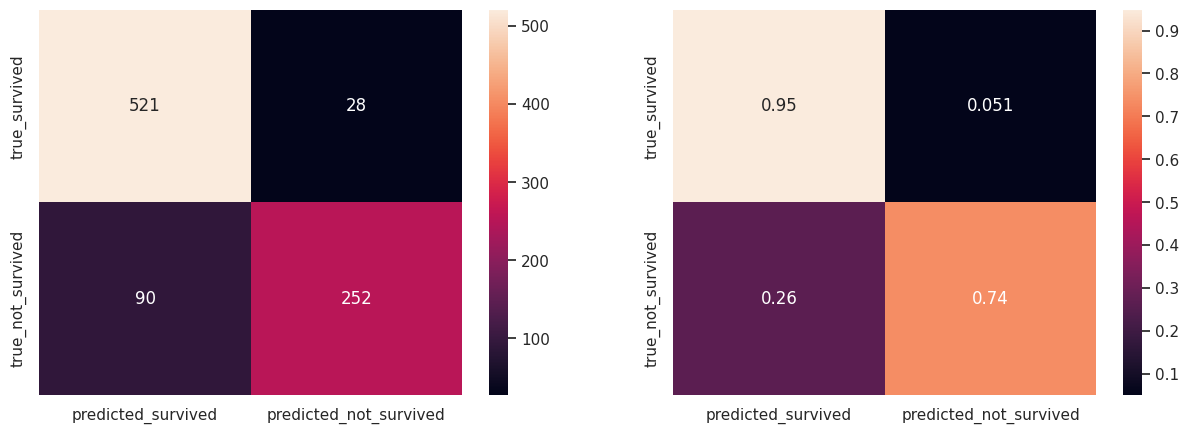

In [36]:
#Матрица неточностей/ошибок (confusion matrix)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
sns.set()

#n_estimators = 8, max_depth = 11 and random_state = 2
model = RandomForestClassifier(n_estimators=8, max_depth=11, random_state=2)
model.fit(X_train, y_train)
y_pred_random_forest_training_set = model.predict(X_train)
acc_random_forest = round(model.score(X_train, y_train) * 100, 2)
print("Accuracy: %i %% \n"%acc_random_forest)

class_names = ['survived', 'not_survived']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train, y_pred_random_forest_training_set)

cnf_matrix_percent = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]


true_class_names = ['true_survived', 'true_not_survived']
predicted_class_names = ['predicted_survived', 'predicted_not_survived']

df_cnf_matrix = pd.DataFrame(cnf_matrix, 
                             index = true_class_names,
                             columns = predicted_class_names)

df_cnf_matrix_percent = pd.DataFrame(cnf_matrix_percent, 
                                     index = true_class_names,
                                     columns = predicted_class_names)

plt.figure(figsize = (15,5))

plt.subplot(121)
sns.heatmap(df_cnf_matrix, annot=True, fmt='d')

plt.subplot(122)
sns.heatmap(df_cnf_matrix_percent, annot=True)

In [37]:
# Подготовка данных
features = X_train.columns.tolist()  # Получаем список признаков
X_test = test_data[features]  # Убедимся, что X_test содержит те же признаки, что и X_train

# Обучение модели
#n_estimators = 8, max_depth = 11 and random_state = 2
model = RandomForestClassifier(n_estimators=8, max_depth=11, random_state=2)
model.fit(X_train, y_train)

# Предсказание на тестовых данных
predictions = model.predict(X_test)

# Сохранение предсказаний в CSV файл
output = pd.DataFrame({'PassengerId': test_data.passengerid, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
